In [1]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

In [10]:
from unsloth import FastVisionModel


import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [11]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.50.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [13]:

model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ

)

In [14]:
from datasets import load_dataset

ds = load_dataset("unsloth/LaTeX_OCR",split = "train")

In [15]:
ds


Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

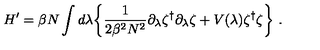

In [16]:
ds[2]["image"]

In [17]:
ds[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

In [18]:
Statement = "Convert the following mathematical equation into latex form"

def convert_to_conversation(sample):
  conversation = [
      {"role": "user",
       "content": [
           {"type": "text", "text": Statement},
           {"type": "image", "image": sample["image"]}
       ]
       },
      {"role": "assistant",
       "content": [
           {"type": "text", "text": sample["text"]}
       ]
       }
  ]
  return {"messages": conversation}



In [19]:
converted_dataset = ds.map(convert_to_conversation)

In [20]:
converted_dataset[1]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x50>,
 'text': 'D _ { \\mu } ^ { \\alpha \\beta } \\bar { A } _ { \\mu } ^ { \\alpha \\beta } = 0 ,',
 'messages': [{'content': [{'image': None,
     'text': 'Convert the following mathematical equation into latex form',
     'type': 'text'},
    {'image': {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00x\x00\x00\x002\x08\x02\x00\x00\x00\x18\xc5\x88\x8f\x00\x00\x08\x10IDATx\x9c\xed\x99[HT]\x1b\xc7\x9f}r\xd7x\x9a\t\x83N&QP\x84\x84 eT\x96\x96\x87J"\xbaI\xc4\x0e\x17F\xde\x04\xd6X\x92f\x99\x8e\x14b\x17\xde\x14\x15\xa4X\x18\x05)\x15\xa9\x91\x8a&\x94\xddDdvQx\x82\xc4\xc6\x06\xc7ft\xc6}Z{}\x17\x0bw\xe3\xf1\x9b\xf1\x9dwW\xdf\xb7\x7f\x172\xb3f\xaf\xff^\xeb\xbf\x9f\xf5<km)\x8c1\x18\xfc\xfb\xd0\xc1\x95\xc3\x18\x07\xeb\xc9\x05Q\xeaO\x80\r\xa2\x16B\x88a\x989\x7fRU\x15!\xa4}e\x18\x86\xa6\x17z\xc6\x0bH\xfd\xa5P\xc1\x8a\x1aUUi\x9a\x1e\x19\x19\x11Eq\xed\xda\xb5\x00\x801\xa6(\xea\xf7J\xfd9\xcc\x11\xd1sZ\xaf\xcd\x13cLb\x93\xa2(\

In [24]:
FastVisionModel.for_inference(model)
image = ds[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image", "image" : image},
        {"type": "text", "text": instruction}
    ]}
]


input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,

    return_tensors = "pt"

).to("cuda")


In [25]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)


```latex
H' = \beta N \int d\lambda \left\{ \frac{1}{2\beta^2 N^2} \partial_\lambda \zeta^\dagger \partial_\lambda \zeta + V(\lambda) \zeta^\dagger \zeta \right\}.
```<|im_end|>


Training SFTT

In [26]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

In [27]:
FastVisionModel.for_training(model) # Enable for training!

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2_5_VLForConditionalGeneration(
      (visual): Qwen2_5_VisionTransformerPretrainedModel(
        (patch_embed): Qwen2_5_VisionPatchEmbed(
          (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
        (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
        (blocks): ModuleList(
          (0-31): 32 x Qwen2_5_VLVisionBlock(
            (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
            (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
            (attn): Qwen2_5_VLVisionSdpaAttention(
              (qkv): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=16, bias=False)
                )
                (lora_B): ModuleD

In [47]:
trainer = SFTTrainer(
    model = model,
    tokenizer=tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps = 5,
        max_steps=30,
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to = "none",
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [40]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.068 GB of memory reserved.


In [51]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

Peak reserved memory = 6.068 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 41.164 %.
Peak reserved memory for training % of max memory = 0.0 %.


Inferernce


In [46]:
FastVisionModel.for_inference(model)
image = ds[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

```latex
H' = \beta N \int d\lambda \left\{ \frac{1}{2\beta^2 N^2} \partial_\lambda \zeta^\dagger \partial_\lambda \zeta + V(\lambda) \zeta^\dagger \zeta \right\}.
```<|im_end|>


In [54]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")

[]

In [58]:
 # Online saving